In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')


In [55]:
import pandas as pd
from mlforecast import MLForecast
from xgboost import XGBRegressor
from utilsforecast.plotting import plot_series
from matplotlib import pyplot as plt
from window_ops.rolling import rolling_mean, rolling_std, rolling_min, rolling_max
from mlforecast.target_transforms import Differences
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.seasonal import STL

In [56]:
df=pd.read_csv('MLTempDataset.csv')
df.drop(columns=['Unnamed: 0',],inplace=True)#'Datetime1'
df1=df.copy()
df1['unique_id']='h1'
# df1['unique_id']=
df1['ds']=pd.to_datetime(df['Datetime'])
df1['y']=df['DAYTON_MW']
df1.drop(columns=['Datetime','DAYTON_MW','Datetime1'],inplace=True)
df1.head()

,unique_id,ds,y
0,h1,2022-01-04 00:00:00,20.867
1,h1,2022-01-04 01:00:00,21.000
2,h1,2022-01-04 02:00:00,20.867
3,h1,2022-01-04 03:00:00,20.650
4,h1,2022-01-04 04:00:00,20.400


In [57]:
trainbef=df1[:5340]
testbef=df1[5340:]
trainbef.shape,testbef.shape

((5340, 3), (1336, 3))

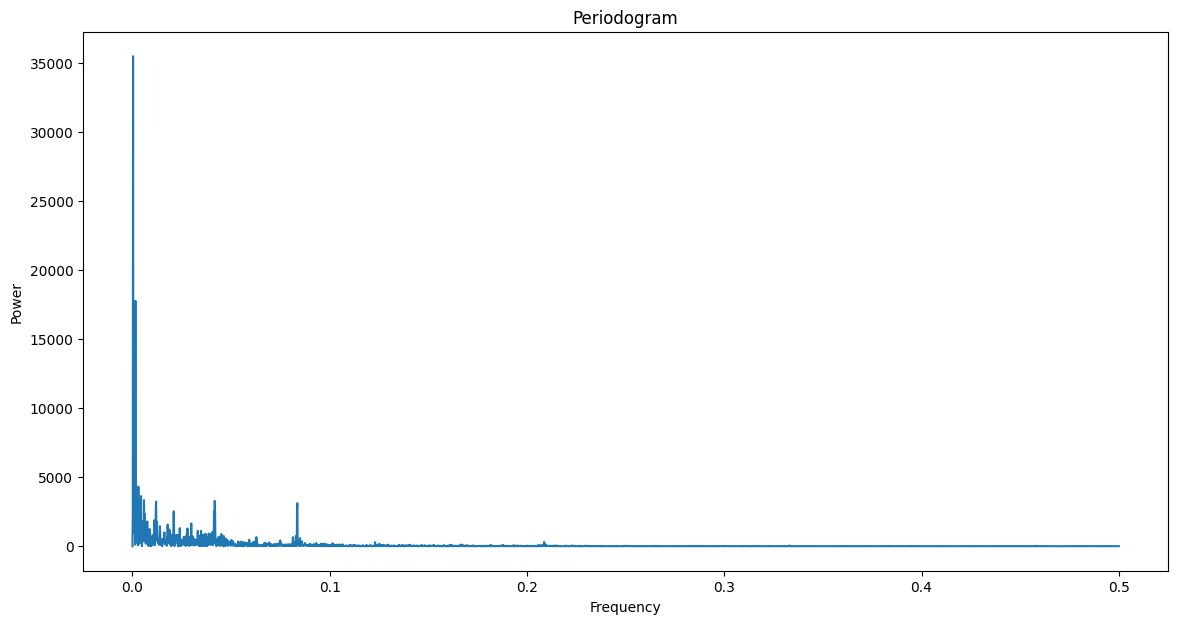

In [58]:
from scipy.signal import periodogram

frequencies, spectrum = periodogram(df1['y'])
plt.figure(figsize=(14, 7))
plt.plot(frequencies, spectrum)
plt.title('Periodogram')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

In [208]:
max_idx = np.argmax(spectrum)
second_max_idx = np.argsort(spectrum)[-2]  # Get the second largest index

# Get the maximum and second maximum values
max_value = spectrum[max_idx]
second_max_value = spectrum[second_max_idx]

# Get the corresponding frequencies
max_freq = frequencies[max_idx]
second_max_freq = frequencies[second_max_idx]

In [209]:
max_freq, second_max_freq

(np.float64(0.0002995805871779509), np.float64(0.0014979029358897543))

In [210]:
1/max_freq, 1/second_max_freq

(np.float64(3338.0), np.float64(667.6))

In [255]:
seasonal_period=667

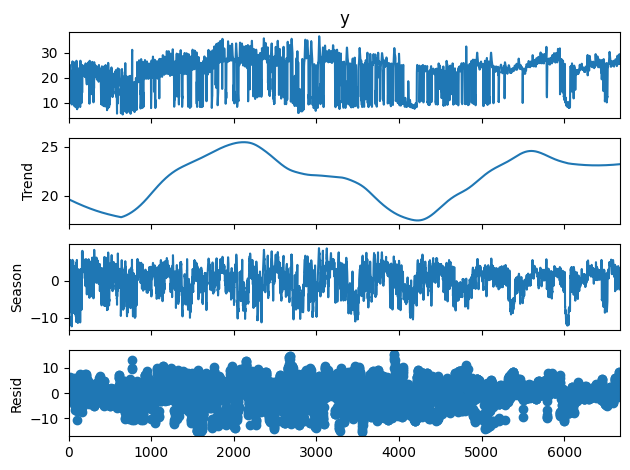

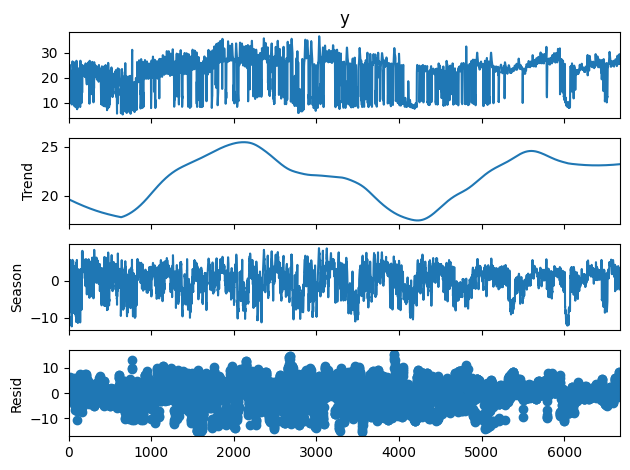

In [256]:
stl = STL(df1['y'],period=seasonal_period)
result=stl.fit()
result.plot()

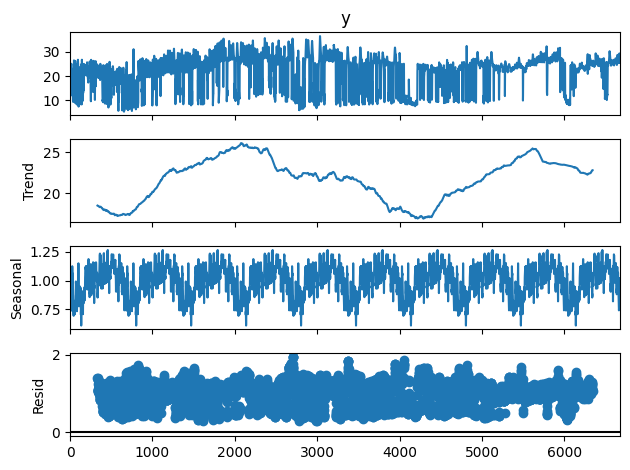

In [215]:
from statsmodels.tsa.seasonal import seasonal_decompose
result2 = seasonal_decompose(df1['y'], model='multiplicative', period=seasonal_period)
result2.plot()
plt.show()

In [257]:
trend=result.trend
trend.head()
seasonal=result.seasonal

In [258]:
a=pd.DataFrame(trend)
a.shape

(6676, 1)

In [259]:
a['ds']=df1['ds']
a['unique_id']=df1['unique_id']
a['y']=a['trend']

In [260]:
a=a.dropna().reset_index(drop=True)
a.head()

,trend,ds,unique_id,y
0,19.671413,2022-01-04 00:00:00,h1,19.671413
1,19.667384,2022-01-04 01:00:00,h1,19.667384
2,19.663358,2022-01-04 02:00:00,h1,19.663358
3,19.659334,2022-01-04 03:00:00,h1,19.659334
4,19.655312,2022-01-04 04:00:00,h1,19.655312


In [261]:
a.shape

(6676, 4)

In [262]:
train=a[:5340]
test=a[5340:]
train.shape,test.shape

((5340, 4), (1336, 4))

In [263]:
model=XGBRegressor(random_state=990,learning_rate=0.01,n_estimators=500,max_depth=10,reg_lambda=0.2)
ftsc=MLForecast(
    models={
        'xgb':model,
        # 'prophet':ProphetWrapper(),
    },
    freq='H',
    lags=[168,30],
    lag_transforms={
        30:[(rolling_mean,30),(rolling_std,30),(rolling_min,30),(rolling_max,30)],
        168:[(rolling_mean,168),(rolling_std,168),(rolling_min,168),(rolling_max,168)],
    #     350:[(rolling_mean,350),(rolling_std,350),(rolling_min,350),(rolling_max,350)],
    #     720:[(rolling_mean,720),(rolling_std,720),(rolling_min,720),(rolling_max,720)]
    },
    target_transforms=[Differences([350])],
    date_features=['hour','day','weekday','month','year'],
)
ftsc.fit(train,id_col='unique_id',time_col='ds',target_col='y')
# min_child_weight=
# ,gamma=
# ,subsample=
# objective="reg:squarederror",

MLForecast(models=[xgb], freq=H, lag_features=['lag168', 'lag30', 'rolling_mean_lag30_window_size30', 'rolling_std_lag30_window_size30', 'rolling_min_lag30_window_size30', 'rolling_max_lag30_window_size30', 'rolling_mean_lag168_window_size168', 'rolling_std_lag168_window_size168', 'rolling_min_lag168_window_size168', 'rolling_max_lag168_window_size168'], date_features=['hour', 'day', 'weekday', 'month', 'year'], num_threads=1)

In [264]:
preds=ftsc.predict(test.shape[0])
preds.head()

,unique_id,ds,xgb
0,h1,2022-08-14 12:00:00,23.592926
1,h1,2022-08-14 13:00:00,23.600031
2,h1,2022-08-14 14:00:00,23.607129
3,h1,2022-08-14 15:00:00,23.609067
4,h1,2022-08-14 16:00:00,23.616154


In [265]:
# seasonalx=seasonal[5340:]
# 24*7*12

In [266]:
seasonalx = np.tile(seasonal[-seasonal_period:], int(np.ceil( 1336 / seasonal_period)))[:1336]
seasonalx = pd.Series(seasonalx, index=test.index)
seasonalx=pd.DataFrame(seasonalx)

In [267]:
seasonalx['ds']=pd.to_datetime(test['ds'])
seasonalx['z']=seasonalx[0]
seasonalx['unique_id']='h1'

In [268]:
seasonalx.head()

,0,ds,z,unique_id
5340,-6.628247,2022-08-14 12:00:00,-6.628247,h1
5341,-6.984357,2022-08-14 13:00:00,-6.984357,h1
5342,-6.894578,2022-08-14 14:00:00,-6.894578,h1
5343,-7.740022,2022-08-14 15:00:00,-7.740022,h1
5344,-8.799644,2022-08-14 16:00:00,-8.799644,h1


In [269]:
seasonalx=pd.DataFrame(seasonalx)
seasonalx['y']=seasonalx['z']
seasonalx=seasonalx.reset_index()
seasonalx.head()

,index,0,ds,z,unique_id,y
0,5340,-6.628247,2022-08-14 12:00:00,-6.628247,h1,-6.628247
1,5341,-6.984357,2022-08-14 13:00:00,-6.984357,h1,-6.984357
2,5342,-6.894578,2022-08-14 14:00:00,-6.894578,h1,-6.894578
3,5343,-7.740022,2022-08-14 15:00:00,-7.740022,h1,-7.740022
4,5344,-8.799644,2022-08-14 16:00:00,-8.799644,h1,-8.799644


In [270]:
seasonalx.shape,preds.shape

((1336, 6), (1336, 3))

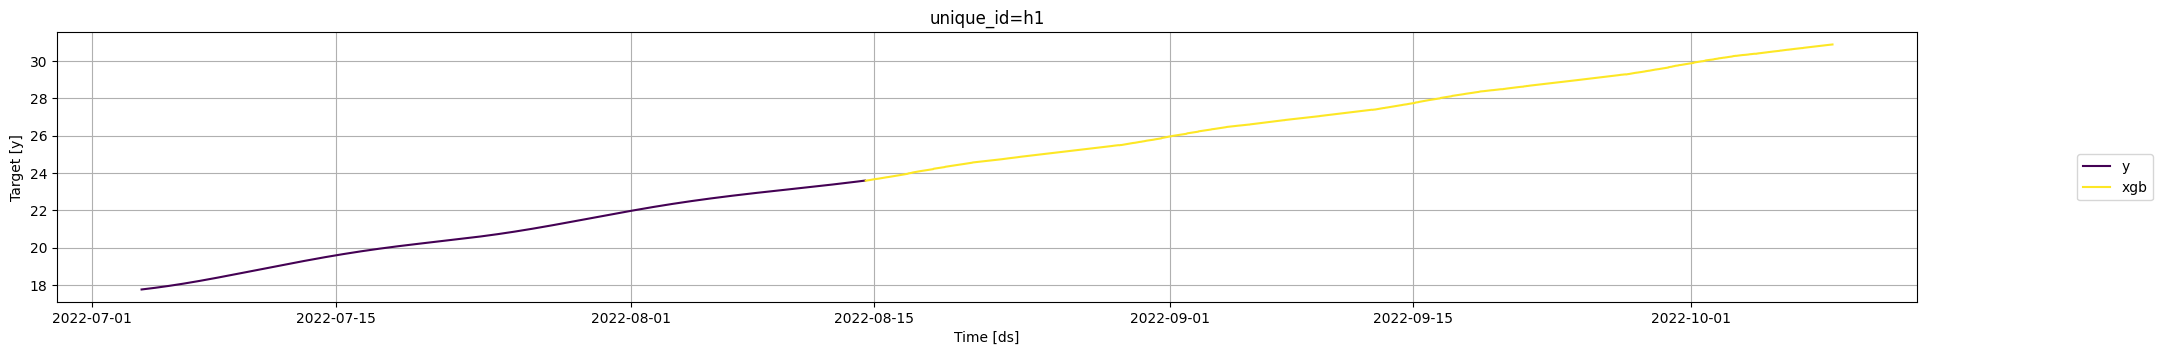

In [271]:
plot_series(train,preds,max_insample_length=1000)

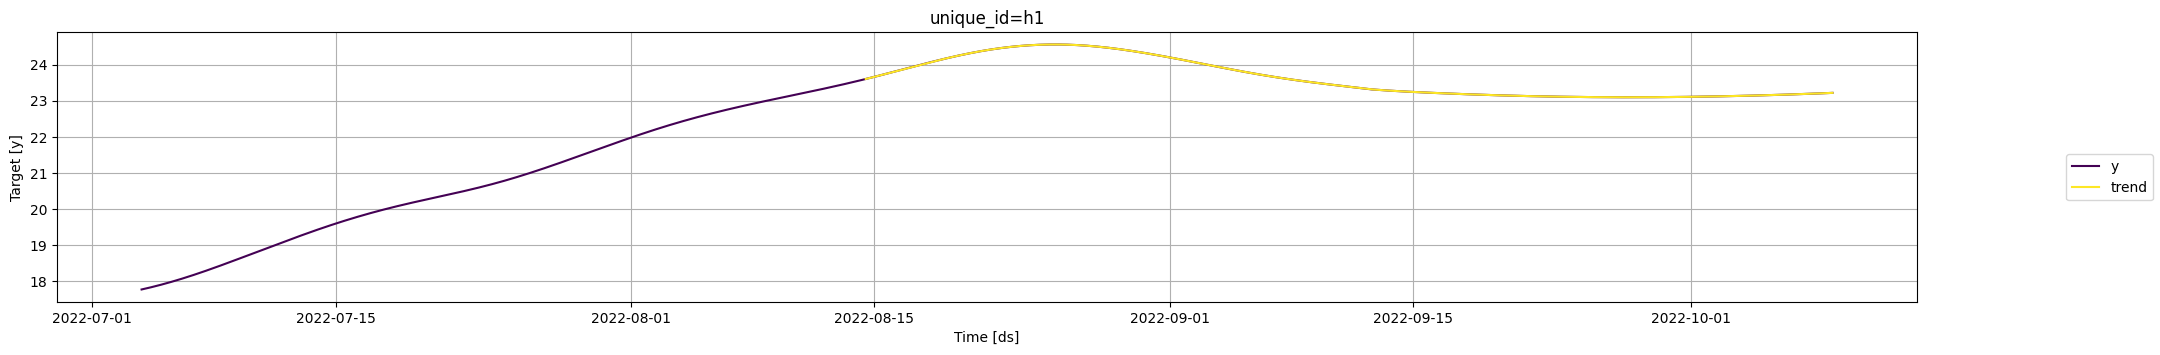

In [272]:
plot_series(train,test,max_insample_length=1000)

In [273]:
mse_test = mean_squared_error(test['y'], preds['xgb'])
mse_test

np.float64(20.027202663960953)

In [274]:
trainbef.head()

,unique_id,ds,y
0,h1,2022-01-04 00:00:00,20.867
1,h1,2022-01-04 01:00:00,21.000
2,h1,2022-01-04 02:00:00,20.867
3,h1,2022-01-04 03:00:00,20.650
4,h1,2022-01-04 04:00:00,20.400


In [275]:
preds['seas+xgb']=preds['xgb']*(seasonalx['y'])
preds['seas+xgb']=(preds['seas+xgb']/df1['y'].mean())+df1['y'].mean()
p=preds.copy()
p.head()

,unique_id,ds,xgb,seas+xgb
0,h1,2022-08-14 12:00:00,23.592926,14.541506
1,h1,2022-08-14 13:00:00,23.600031,14.152690
2,h1,2022-08-14 14:00:00,23.607129,14.247917
3,h1,2022-08-14 15:00:00,23.609067,13.329003
4,h1,2022-08-14 16:00:00,23.616154,12.175201


In [276]:
preds['seas+xgb'].median()

np.float64(23.170583407574362)

In [277]:
p.drop(columns=['xgb'],inplace=True)

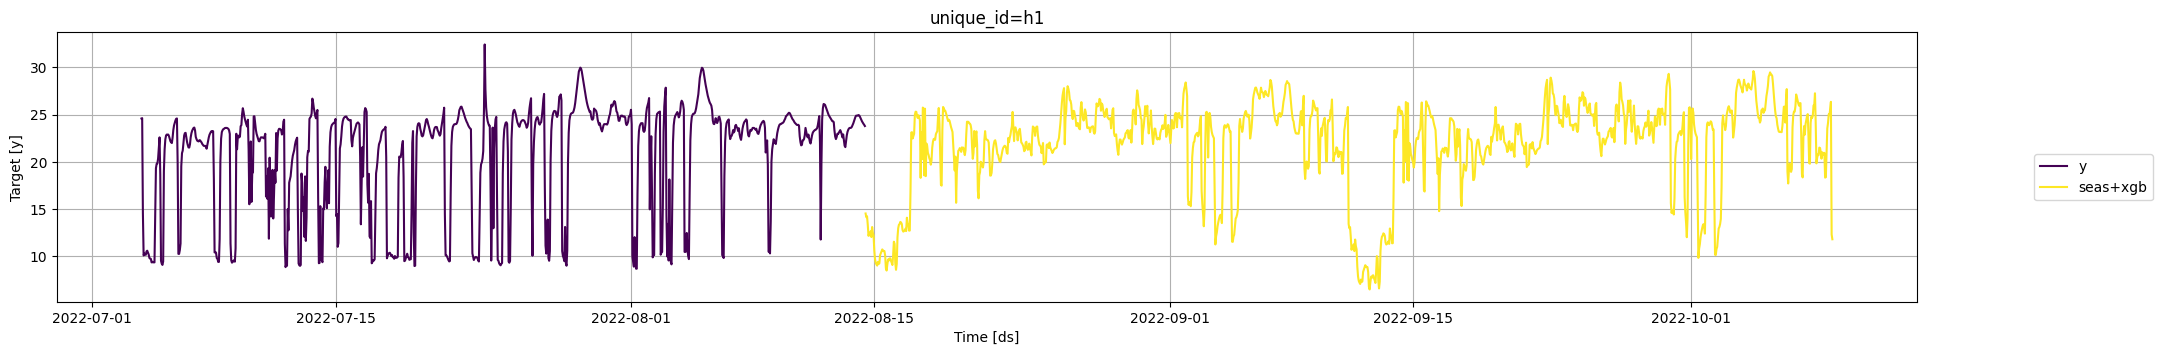

In [278]:
plot_series(trainbef,p,max_insample_length=1000)

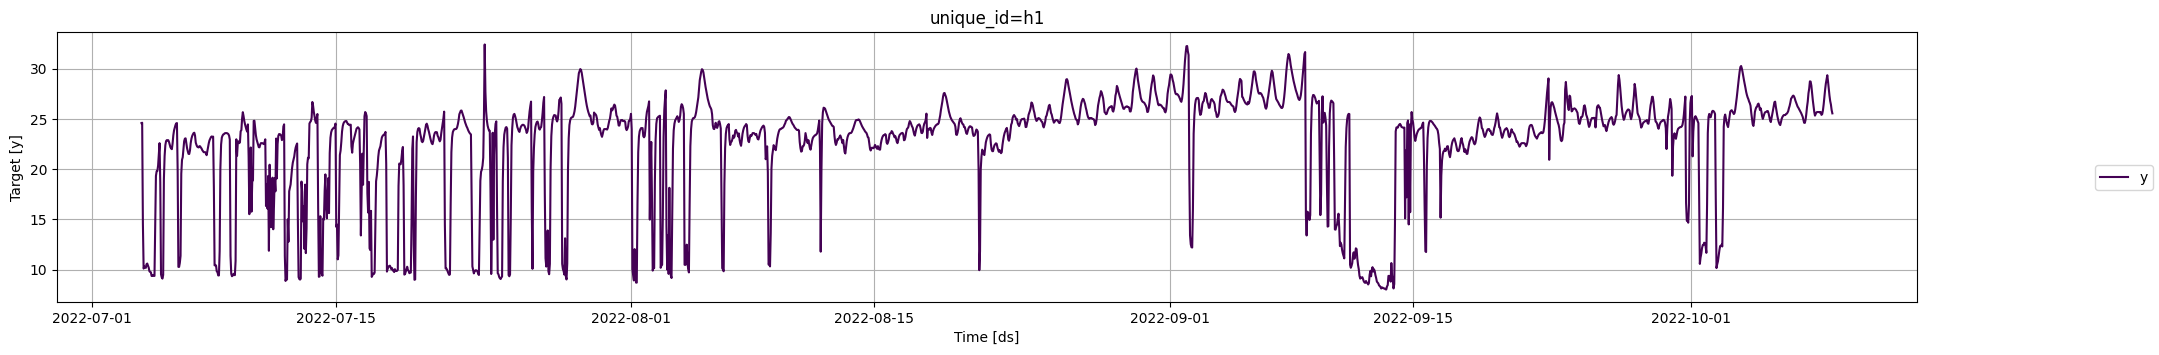

In [279]:
plot_series(trainbef,testbef,max_insample_length=1000)

In [280]:
mse_test = mean_squared_error(testbef['y'], p['seas+xgb'])
mse_test

np.float64(21.106119289861564)

In [281]:
trainbef.head()

,unique_id,ds,y
0,h1,2022-01-04 00:00:00,20.867
1,h1,2022-01-04 01:00:00,21.000
2,h1,2022-01-04 02:00:00,20.867
3,h1,2022-01-04 03:00:00,20.650
4,h1,2022-01-04 04:00:00,20.400


In [282]:
p['y']=p['seas+xgb']
p.tail()

,unique_id,ds,seas+xgb,y
1331,h1,2022-10-08 23:00:00,24.951211,24.951211
1332,h1,2022-10-09 00:00:00,25.576532,25.576532
1333,h1,2022-10-09 01:00:00,26.361033,26.361033
1334,h1,2022-10-09 02:00:00,12.320573,12.320573
1335,h1,2022-10-09 03:00:00,11.813481,11.813481


In [283]:
concatenated_df = pd.concat([trainbef, p]).sort_values(by='ds').reset_index(drop=True)

In [284]:
concatenated_df.drop(columns=['seas+xgb'],inplace=True)
concatenated_df.tail()

,unique_id,ds,y
6671,h1,2022-10-08 23:00:00,24.951211
6672,h1,2022-10-09 00:00:00,25.576532
6673,h1,2022-10-09 01:00:00,26.361033
6674,h1,2022-10-09 02:00:00,12.320573
6675,h1,2022-10-09 03:00:00,11.813481


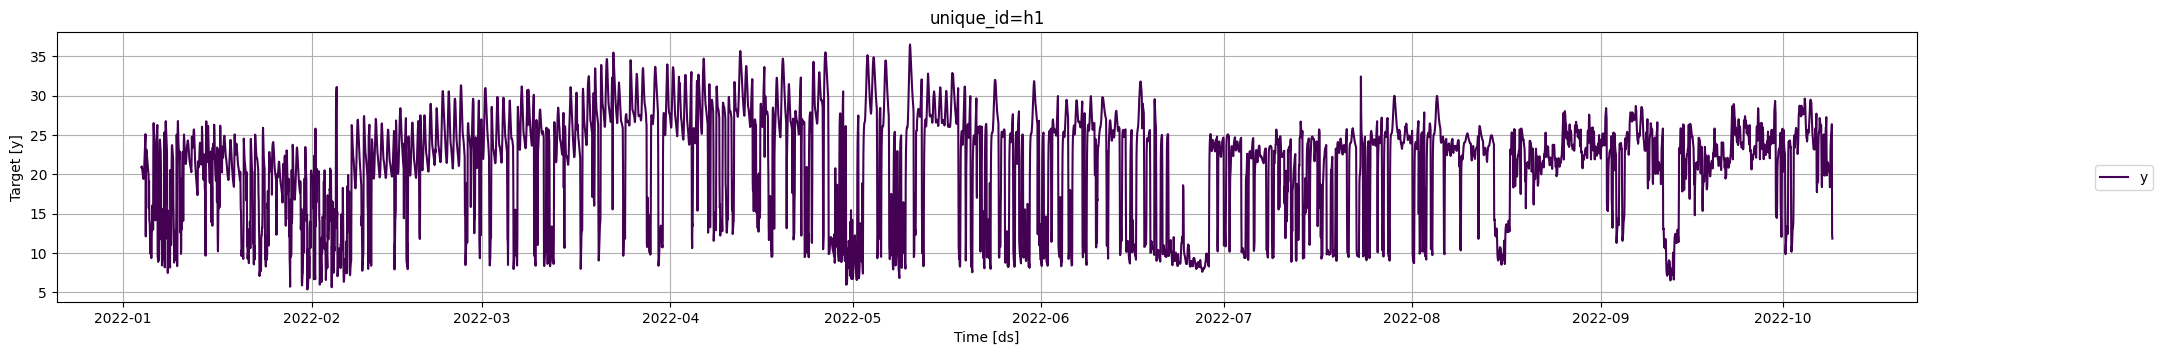

In [285]:
plot_series(concatenated_df)

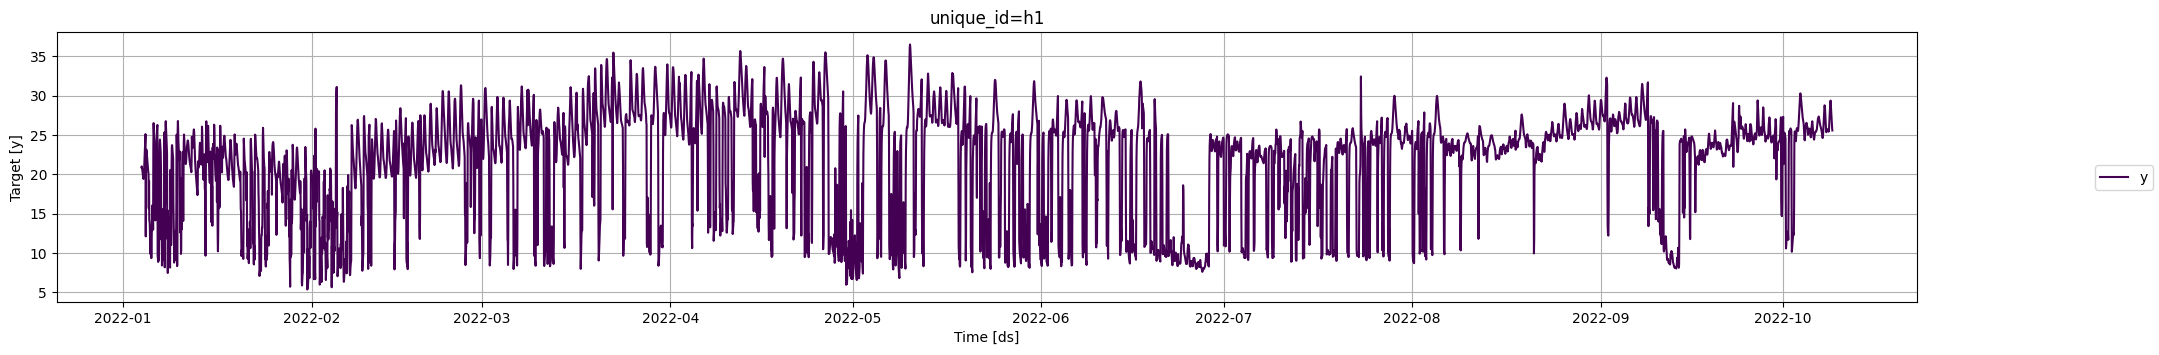

In [286]:
plot_series(df1)